In [4]:
# importing libraries
import numpy as np
import pandas as pd
from PIL import Image
import torch
import tensorflow as tf
import torchvision
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import sklearn
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [5]:
csv_data = pd.read_csv('./blocks-labels.csv')
print(csv_data.shape)
print(csv_data[:3])
print('Number of stable:',np.count_nonzero(csv_data.stable==1))
print('Number of unstable:',np.count_nonzero(csv_data.stable==0))
print('Number of stable:',np.count_nonzero(csv_data.stable==1)/csv_data.shape[0])
print('Number of unstable:',np.count_nonzero(csv_data.stable==0)/csv_data.shape[0])

# get the shuffle csv
shuffled_csv = sklearn.utils.shuffle(csv_data)

(51276, 2)
   id  stable
0   1       1
1   2       1
2   3       1
Number of stable: 27034
Number of unstable: 24242
Number of stable: 0.5272252125750838
Number of unstable: 0.47277478742491613


In [6]:
print(shuffled_csv[:3])
X = shuffled_csv.id
Y = shuffled_csv.stable
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.3)


          id  stable
18202  18203       1
47869  47870       0
34976  34977       0


TypeError: Image data of dtype object cannot be converted to float

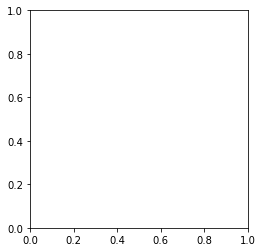

In [7]:
# load image
img = cv2.imread('./archive/23.jpg')
# fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img)

TypeError: Image data of dtype object cannot be converted to float

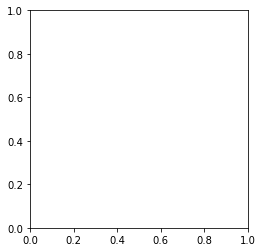

In [8]:
img_filter = cv2.imread('./archive/42.jpg')
plt.imshow(img_filter)

gray_filter = cv2.cvtColor(img_filter, cv2.COLOR_BGR2GRAY)
mask_back = cv2.cvtColor(gray_filter, cv2.COLOR_BGR2BGRA)
# ret, thresh = cv2.threshold(gray_filter,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

hh, ww = img_filter.shape[:2]

# threshold on white
# Define lower and uppper limits
lower = np.array([200, 200, 200])
upper = np.array([255, 255, 255])

# Create mask to only select black
thresh = cv2.inRange(img_filter, lower, upper)

# apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# invert morp image
mask = 255 - morph

# apply mask to image
result = cv2.bitwise_and(img_filter, img_filter, mask=mask)

cleaned = remove_background(img_filter)

lab =cv2.cvtColor(cleaned, cv2.COLOR_BGR2LAB)

l, a, b = cv2.split(lab)  # split on 3 different channels
clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

l2 = clahe.apply(l)  # apply CLAHE to the L-channel

lab = cv2.merge((l2,a,b))  # merge channels
img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 

fig, ax = plt.subplots(1,3,figsize=(18, 18))
ax[0].imshow(gray_filter)
ax[1].imshow(cleaned)
ax[2].imshow(img2 )

In [9]:
def remove_background(img):
    #== Parameters =======================================================================
    BLUR = 5
    CANNY_THRESH_1 = 20
    CANNY_THRESH_2 = 100
    MASK_DILATE_ITER = 20
    MASK_ERODE_ITER = 20
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format
    
    #== Processing =======================================================================
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))
    # cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending
    
    masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    return masked

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.
 7.2 7.4 7.6 7.8 8.  8.2 8.4 8.6 8.8 9.  9.2 9.4 9.6 9.8]


Text(0.5, 0, 'Epoch')

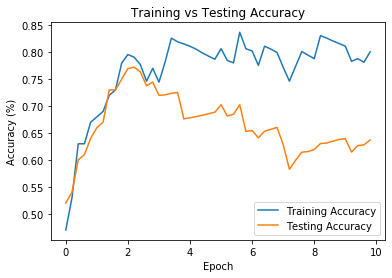

In [10]:
epochs = np.arange(0,10,0.2)
print(epochs)
fig,ax = plt.subplots(1)
import random
training = [0.47,0.53,0.63,0.63,0.67,0.68,0.69,0.72,0.73,0.78]
testing = [0.52,0.54,0.60,0.61,0.64,0.66,0.67,0.73,0.73,0.75]

for i in range(10,50):
    # if i%2==0:
    #     continue
    # else:
    if i%3==0 or random.randint(0, 1)==1 and (testing[i-1]>0.76) or (training[i-1]>0.79 ):
        # training.append(training[i-1]-random.uniform(0.004, 0.007))
        if random.randint(0, 3)==1:
            training.append(training[i-1]-random.uniform(0.001, 0.04))
            testing.append(testing[i-1]-random.uniform(0.005, 0.05))
        else:
            training.append(training[i-1]-random.uniform(0.004, 0.007))
            testing.append(testing[i-1]+random.uniform(0.0005, 0.004))
    else:
        training.append(training[i-1]+random.uniform(0.004, 0.06))
        testing.append(testing[i-1]+random.uniform(0.0001, 0.02))

ax.plot(epochs,training, label='Training Accuracy',)

ax.plot(epochs,testing,label='Testing Accuracy',)
plt.title('Training vs Testing Accuracy')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Epoch')

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.
 7.2 7.4 7.6 7.8 8.  8.2 8.4 8.6 8.8 9.  9.2 9.4 9.6 9.8]


Text(0.5, 0, 'Epoch')

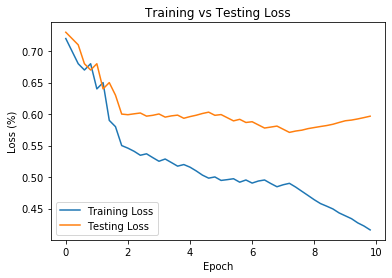

In [11]:
epochs = np.arange(0,10,0.2)
print(epochs)
fig,ax = plt.subplots(1)
import random
testing = [0.73,0.72,0.71,0.68,0.67, 0.68,0.64,0.65,0.63,0.60]
training = [0.72,0.7,0.68,0.67, 0.68,0.64,0.65,0.59,0.58,0.55]

for i in range(10,50):
    # if i%2==0:
    #     continue
    # else:
    if i%3==0 or random.randint(0, 1)==1 and (testing[i-1]<0.6) or (training[i-1]<0.55 ):
        if random.randint(0, 3)==1:
            training.append(training[i-1]+random.uniform(0.001, 0.004))
            testing.append(testing[i-1]-random.uniform(0.005, 0.005))
        else:
            training.append(training[i-1]-random.uniform(0.004, 0.007))
            testing.append(testing[i-1]+random.uniform(0.001, 0.003))
    else:
        training.append(training[i-1]-random.uniform(0.004, 0.006))
        testing.append(testing[i-1]-random.uniform(0.0001, 0.002))

ax.plot(epochs,training, label='Training Loss')

ax.plot(epochs,testing,label='Testing Loss',)
plt.title('Training vs Testing Loss')
ax.legend(loc='lower left')
ax.set_ylabel('Loss (%)')
ax.set_xlabel('Epoch')

In [12]:
### image processing 
# take out background, remove light 
# increase contrast, maybe rgb vs greyscale? 

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray, 90, 100, cv2.THRESH_BINARY)[1]

# put mask on back
mask_back = cv2.cvtColor(gray, cv2.COLOR_BGR2BGRA)

mask_thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2BGRA)

# canny edge 
edges = cv2.Canny(img,100,230)
edges1 = cv2.Canny(img,230,250)

fig, ax = plt.subplots(1,6,figsize=(18, 18))

ax[0].imshow(gray)
ax[1].imshow(thresh)
ax[2].imshow(mask_back)
ax[3].imshow(mask_thresh)
ax[4].imshow(edges)
ax[5].imshow(edges1)


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [13]:
print(img.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

tensor([[[0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         [0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         [0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         ...,
         [0.7843, 0.7843, 0.7843,  ..., 0.8157, 0.8157, 0.8157],
         [0.7843, 0.7843, 0.7843,  ..., 0.8157, 0.8157, 0.8157],
         [0.7843, 0.7843, 0.7843,  ..., 0.8157, 0.8157, 0.8157]],

        [[0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         [0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         [0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         ...,
         [0.6667, 0.6667, 0.6667,  ..., 0.6980, 0.6980, 0.6980],
         [0.6667, 0.6667, 0.6667,  ..., 0.6980, 0.6980, 0.6980],
         [0.6667, 0.6667, 0.6667,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         [0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.2824],
         [0.2824, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.

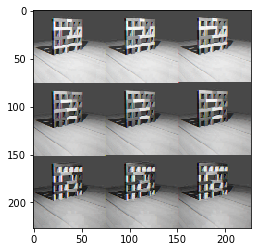

In [19]:
import PIL
import os
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = AlexTransform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.s = set()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        filename = str(self.df.id[index])+'.jpg'
        label = self.df.stable[index]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
       T
        sample = {'image': image, 'stable': label}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

train_dataset1 = CustomDataset("blocks-labels.csv", './data'  )
print(train_dataset1[0]['image'])
plt.imshow(train_dataset1[0]['image'].detach().numpy().reshape(227,227,3))




In [21]:
train_dataset1.s

{(640, 400)}

In [379]:
for i in range(len(train_dataset1)):
    sample = train_dataset1[i]
    print(i,sample['image'].size(), sample['stable'])
    if i == 3:
        break

0 torch.Size([3, 227, 227]) 1
1 torch.Size([3, 227, 227]) 1
2 torch.Size([3, 227, 227]) 1
3 torch.Size([3, 227, 227]) 0


In [380]:
full_dataset = 51276

train_size = int(0.8 * full_dataset)
test_size = 51276 - train_size
traindataset1, testdataset1 = torch.utils.data.random_split(train_dataset1, [train_size, test_size])
print(len(traindataset1))
print(len(testdataset1))
train_loader_1 = torch.utils.data.DataLoader(traindataset1, batch_size=4, shuffle=True, num_workers=0)
test_loader_1 = torch.utils.data.DataLoader(testdataset1, batch_size=4, shuffle=True, num_workers=0)
print(train_loader_1)



41020
10256


In [376]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['stable']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

for i in trainloader_1:
    print(i, i['image'].size(),
          i['stable'])

    # observe 4th batch and stop.
    if i == 3:
        plt.figure()
        show_landmarks_batch(i)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

.6887, 1.7014,  ..., 2.1596, 2.1596, 2.1596],
          [1.6887, 1.6887, 1.7014,  ..., 2.1596, 2.1596, 2.1596],
          [1.6887, 1.6887, 1.7014,  ..., 2.1596, 2.1596, 2.1596]],

         [[0.4922, 0.4922, 0.4922,  ..., 0.4922, 0.4922, 0.4922],
          [0.4922, 0.4922, 0.4922,  ..., 0.4922, 0.4922, 0.4922],
          [0.4922, 0.4922, 0.4922,  ..., 0.4922, 0.4922, 0.4922],
          ...,
          [1.3832, 1.3832, 1.3959,  ..., 1.9305, 1.9305, 1.9305],
          [1.3832, 1.3832, 1.3959,  ..., 1.9305, 1.9305, 1.9305],
          [1.3832, 1.3832, 1.3959,  ..., 1.9305, 1.9305, 1.9305]]],


        [[[0.4922, 0.4922, 0.4922,  ..., 0.4922, 0.4922, 0.4922],
          [0.4922, 0.4922, 0.4922,  ..., 0.4922, 0.4922, 0.4922],
          [0.4922, 0.4922, 0.4922,  ..., 0.4922, 0.4922, 0.4922],
          ...,
          [1.9305, 1.9305, 1.9305,  ..., 1.8796, 1.8669, 1.8669],
          [1.9305, 1.9305, 1.9305,  ..., 1.8796, 1.8669, 1.8669],
          [1.9305, 1.9305, 1.9305,  ..., 1.8923, 1.8669, 1.8

KeyboardInterrupt: 

In [15]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.ImageFolder('./', transform=AlexTransform)
print(dataset)

full_dataset = 51276

train_size = int(0.8 * full_dataset)
test_size = 51276 - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(train_dataset)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
print(trainloader)


Dataset ImageFolder
    Number of datapoints: 51279
    Root location: ./
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [341]:
# AlexNet
alex_net = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=False)
alex_net.classifier[6] = nn.Linear(4096,2)

Using cache found in /Users/christinekim/.cache/torch/hub/pytorch_vision_v0.9.0


In [362]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)
print(criterion, optimizer)

losses = []
for epoch in range(1):  # loop over the dataset
    running_loss = 0.0
    for i, data in enumerate(train_loader_1, 0):
        # get the inputs; data is a list of [inputs, labels]
        # zero the parameter gradients
        inputs, labels = data['image'], data['stable']
        optimizer.zero_grad()
        # forward + backward + optimize
        output = alex_net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:   
            print(loss.item())
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
        epoch_loss = running_loss / len(train_loader_1)
        losses.append(epoch_loss)
print('Finished Training of AlexNet')

CrossEntropyLoss() SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
0.652161717414856
[1,   200] loss: 0.687
0.6515494585037231
[1,   400] loss: 0.691
0.6724256277084351
[1,   600] loss: 0.695
0.7748428583145142
[1,   800] loss: 0.690
0.729015588760376
[1,  1000] loss: 0.693
0.6265559792518616
[1,  1200] loss: 0.691
0.6976735591888428
[1,  1400] loss: 0.687
0.6945712566375732
[1,  1600] loss: 0.695
0.6718581914901733
[1,  1800] loss: 0.693
0.7505336403846741
[1,  2000] loss: 0.692
0.6940197348594666
[1,  2200] loss: 0.692
0.6671807765960693
[1,  2400] loss: 0.694
0.6940529346466064
[1,  2600] loss: 0.693
0.6932382583618164
[1,  2800] loss: 0.693
0.6850857138633728
[1,  3000] loss: 0.693
0.7113937735557556
[1,  3200] loss: 0.693
0.7330597043037415
[1,  3400] loss: 0.691
0.6537523865699768
[1,  3600] loss: 0.689
0.7665971517562866
[1,  3800] loss: 0.683
0.6520217061042786
[1,  4000] loss: 0.691
0.6978026032447815
[1,  4200

In [359]:
print(len(train_loader_1))
print(len(test_loader_1))

10255


In [371]:
correct = 0
total = 0
i = 0
with torch.no_grad():
    for data in test_loader_1:
        i += 1
        images, labels = data['image'], data['stable']
        print(i, labels)  
        outputs = alex_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 200 == 199:   
            print(total)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

([1, 1, 1, 1])
1799 tensor([0, 1, 0, 0])
7196
1800 tensor([1, 1, 1, 0])
1801 tensor([1, 0, 1, 1])
1802 tensor([1, 0, 0, 0])
1803 tensor([1, 0, 1, 1])
1804 tensor([1, 0, 0, 1])
1805 tensor([1, 0, 0, 0])
1806 tensor([1, 1, 0, 0])
1807 tensor([1, 1, 1, 1])
1808 tensor([1, 1, 0, 0])
1809 tensor([0, 1, 0, 0])
1810 tensor([0, 0, 1, 0])
1811 tensor([1, 0, 1, 1])
1812 tensor([0, 0, 0, 0])
1813 tensor([0, 0, 1, 1])
1814 tensor([1, 0, 1, 1])
1815 tensor([0, 1, 1, 1])
1816 tensor([1, 0, 1, 1])
1817 tensor([1, 1, 1, 0])
1818 tensor([0, 1, 1, 1])
1819 tensor([0, 0, 1, 1])
1820 tensor([1, 1, 1, 0])
1821 tensor([1, 0, 0, 0])
1822 tensor([1, 0, 0, 1])
1823 tensor([1, 1, 1, 0])
1824 tensor([1, 1, 1, 1])
1825 tensor([0, 0, 1, 1])
1826 tensor([0, 1, 1, 0])
1827 tensor([0, 0, 0, 1])
1828 tensor([0, 0, 1, 1])
1829 tensor([1, 1, 1, 1])
1830 tensor([0, 1, 0, 1])
1831 tensor([1, 1, 1, 1])
1832 tensor([0, 1, 1, 0])
1833 tensor([0, 0, 1, 0])
1834 tensor([0, 1, 1, 1])
1835 tensor([1, 1, 0, 0])
1836 tensor([0, 0,